In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import keras
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras import datasets, layers, models
from keras.models import Sequential
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import io
import cv2
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, auc, accuracy_score, roc_curve

In [2]:
pwd 

'c:\\Users\\User\\Desktop\\emotion'

In [3]:
batch_size = 64
img_height = 140
img_width = 140

In [13]:
train_ds_1 = tf.keras.utils.image_dataset_from_directory(
    'c:\\Users\\User\\Desktop\\emotion\\dataset\\train',
    subset ="training",
    validation_split = 0.2,
    seed = 123,
    batch_size = batch_size,
    image_size =(img_height, img_width),
    color_mode = "rgb"
)

Found 26712 files belonging to 7 classes.
Using 21370 files for training.


In [14]:
val_ds_1 = tf.keras.utils.image_dataset_from_directory(
    'c:\\Users\\User\\Desktop\\emotion\\dataset\\train',
    seed =123,
    subset = "validation",
    validation_split = 0.2,
    image_size = (img_height, img_width),
    batch_size = batch_size,
    color_mode = "rgb"
)

Found 26712 files belonging to 7 classes.
Using 5342 files for validation.


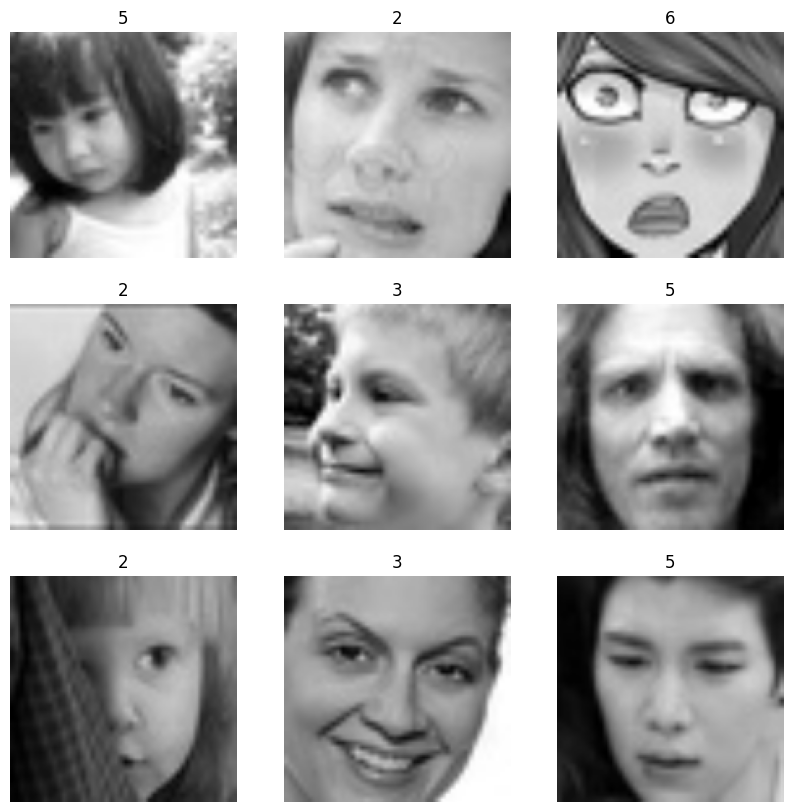

In [17]:
import matplotlib.pyplot as plt

# Take one batch from dataset
for images, labels in train_ds_1.take(1):
    plt.figure(figsize=(10,10))

    for i in range(9):   # show 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[i].numpy())
        plt.axis("off")

    plt.show()

In [ ]:
#normalization_layer = tf.keras.layers.Rescaling(1./255)
#train_ds_1 =train_ds_1.map(
#    lambda x, y:(normalization_layer(x),y))
#Without prefetching: GPU sits idle waiting for data
#Training slower

#With prefetching: Data pipeline and model run in parallel
# Training becomes smoother and faster

train_ds_1 = train_ds_1.map(lambda x, y:(preprocess_input(tf.cast(x, tf.float32)), y))
val_ds_1 = val_ds_1.map(lambda x, y:(preprocess_input(tf.cast(x, tf.float32)), y))
AUTOTUNE = tf.data.AUTOTUNE
train_ds_1 = train_ds_1.cache().prefetch(buffer_size = AUTOTUNE)
val_ds_1 = val_ds_1.cache().prefetch(buffer_size = AUTOTUNE)

ResNet-50 model

In [7]:
base_model = keras.applications.ResNet50(
    weights = 'imagenet',
    input_shape=(140, 140, 3),
    include_top= False)
 # this doesn't include the Image classifier at the top

base_model.trainable = False #this freezes the base model.

inputs = keras.Input(shape=(140, 140, 3))
x = base_model(inputs, training = False)
x = keras.layers.GlobalAveragePooling2D() (x)
x = keras.layers.Dense(256, activation='relu') (x)
x = layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(7, activation="softmax") (x)
model = keras.Model(inputs, outputs)


In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
history = model.fit(train_ds_1, validation_data=val_ds_1, epochs = 5)

Epoch 1/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 628s 2s/step - accuracy: 0.4139 - loss: 1.5693 - val_accuracy: 0.4854 - val_loss: 1.3764
Epoch 2/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 1673s 5s/step - accuracy: 0.4720 - loss: 1.4113 - val_accuracy: 0.5118 - val_loss: 1.3309
Epoch 3/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 585s 2s/step - accuracy: 0.4914 - loss: 1.3648 - val_accuracy: 0.5227 - val_loss: 1.2955
Epoch 4/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 586s 2s/step - accuracy: 0.5009 - loss: 1.3293 - val_accuracy: 0.5277 - val_loss: 1.2767
Epoch 5/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 584s 2s/step - accuracy: 0.5118 - loss: 1.3057 - val_accuracy: 0.5358 - val_loss: 1.2536


In [8]:
history = model.fit(train_ds_1, validation_data=val_ds_1, epochs = 10)

Epoch 1/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 620s 2s/step - accuracy: 0.4315 - loss: 1.5144 - val_accuracy: 0.4950 - val_loss: 1.3440
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 583s 2s/step - accuracy: 0.5061 - loss: 1.3187 - val_accuracy: 0.5133 - val_loss: 1.2933
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 580s 2s/step - accuracy: 0.5333 - loss: 1.2516 - val_accuracy: 0.5246 - val_loss: 1.2713
Epoch 4/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 3222s 9s/step - accuracy: 0.5499 - loss: 1.2075 - val_accuracy: 0.5299 - val_loss: 1.2604
Epoch 5/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 1179s 3s/step - accuracy: 0.5638 - loss: 1.1748 - val_accuracy: 0.5302 - val_loss: 1.2550
Epoch 6/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 587s 2s/step - accuracy: 0.5722 - loss: 1.1490 - val_accuracy: 0.5314 - val_loss: 1.2528
Epoch 7/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 600s 2s/step - accuracy: 0.5792 - loss: 1.1278 - val_accuracy: 0.5320 - val_loss: 1.2526
Epoch 8/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 18689s 52s/step - accuracy: 0.5850 - loss: 1.1099 - val

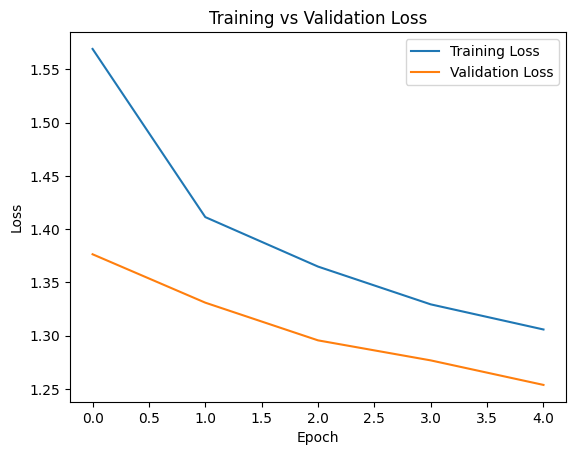

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

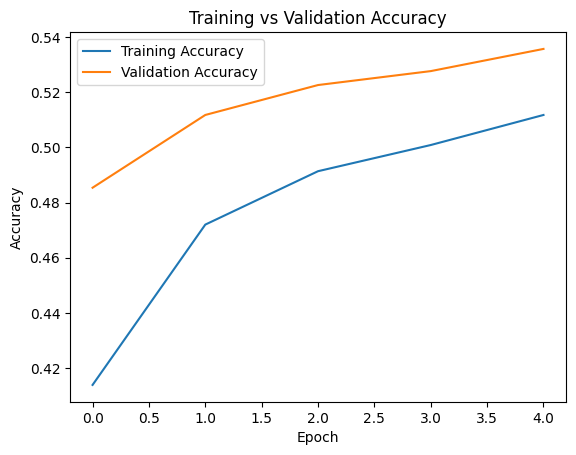

In [12]:
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

Improving the accuracy of the transfer learning: Fine-tuning the model

In [ ]:
data_aug =tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
    
])

In [ ]:
inputs = keras.Input(shape=(140, 140, 3))
x = data_aug(inputs)

In [18]:
base_model.trainable = True
base_learning_rate = 0.0001
print("Number of layers in a base-model:", len(base_model.layers))
#fine tune from this layer onwards
fine_tune_from= 100
#freezing all the layers from 0 to 99
for layer in base_model.layers[:fine_tune_from]:
    layer.trainable= False


Number of layers in a base-model: 175


In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate= base_learning_rate/10), 
    loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 140, 140, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 5, 5, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,114,055 (91.99 MB)

 Trainable params: 19,979,271 (76.21 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

In [21]:
history1 = model.fit(train_ds_1, validation_data=val_ds_1, epochs = 10)

Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 1248s 4s/step - accuracy: 0.3356 - loss: 1.7934 - val_accuracy: 0.4760 - val_loss: 1.3990
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 1672s 5s/step - accuracy: 0.5045 - loss: 1.3481 - val_accuracy: 0.5262 - val_loss: 1.2752
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 1214s 4s/step - accuracy: 0.5758 - loss: 1.1491 - val_accuracy: 0.5548 - val_loss: 1.2109
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 2257s 7s/step - accuracy: 0.6384 - loss: 0.9889 - val_accuracy: 0.5719 - val_loss: 1.1724
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 1246s 4s/step - accuracy: 0.6979 - loss: 0.8363 - val_accuracy: 0.5857 - val_loss: 1.1643
Epoch 6/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 1171s 4s/step - accuracy: 0.7538 - loss: 0.7017 - val_accuracy: 0.5938 - val_loss: 1.1659
Epoch 7/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 1151s 3s/step - accuracy: 0.8110 - loss: 0.5547 - val_accuracy: 0.5958 - val_loss: 1.2069
Epoch 8/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 1149s 3s/step - accuracy: 0.8627 - loss: 0.4253 - 

In [24]:
model.save("C:/Users/User/Desktop/emotion/models/resnet50.keras")

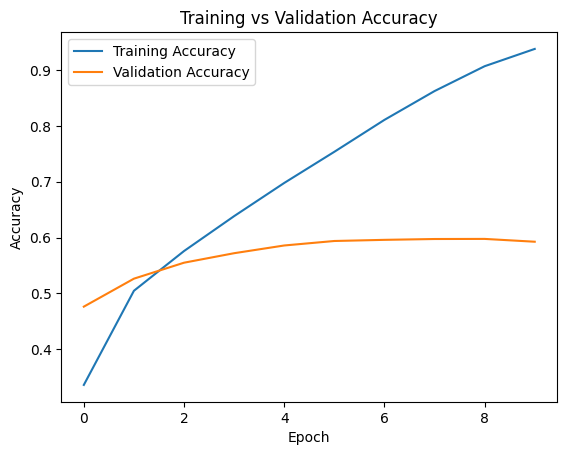

In [23]:
plt.figure()
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

In [25]:
loss, accuracy = model.evaluate(val_ds_1)
print("Validation accuracy:", accuracy)
print("Validation loss:", loss)


84/84 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.5925 - loss: 1.4465
Validation accuracy: 0.5924746990203857
Validation loss: 1.4464954137802124


In [26]:
predictions = model.predict(val_ds_1)

84/84 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step


In [27]:
print(predictions)

[[1.57722770e-05 1.96402834e-05 1.04641244e-02 ... 8.25946790e-06
  1.96593592e-05 9.89467084e-01]
 [1.18927246e-05 2.25243184e-06 9.41024336e-06 ... 1.29972443e-01
  5.28638611e-06 1.57948148e-06]
 [6.95410068e-04 8.17349239e-04 3.80017882e-04 ... 1.38749217e-03
  4.97651426e-03 7.81143463e-05]
 ...
 [1.10269102e-05 2.34809576e-08 6.71899470e-05 ... 9.99898553e-01
  6.84158113e-06 2.21756318e-06]
 [1.81978103e-03 1.68776140e-04 1.34902378e-03 ... 3.81065230e-03
  7.06271618e-04 2.53128732e-04]
 [1.23196214e-01 2.09571645e-02 1.57875568e-01 ... 2.63229042e-01
  4.27184999e-01 6.08856976e-03]]


In [28]:
#argmax()=Return the index of the largest value in an array.
predicted_classes = np.argmax(predictions, axis = 1)

In [29]:
print(predicted_classes)

[6 3 3 ... 4 3 5]


In [30]:
labels_list = []
for images, labels in val_ds_1:
    labels_list.append(labels)

true_labels = np.concatenate(labels_list)

In [31]:
print(true_labels)

[4 6 2 ... 2 4 0]


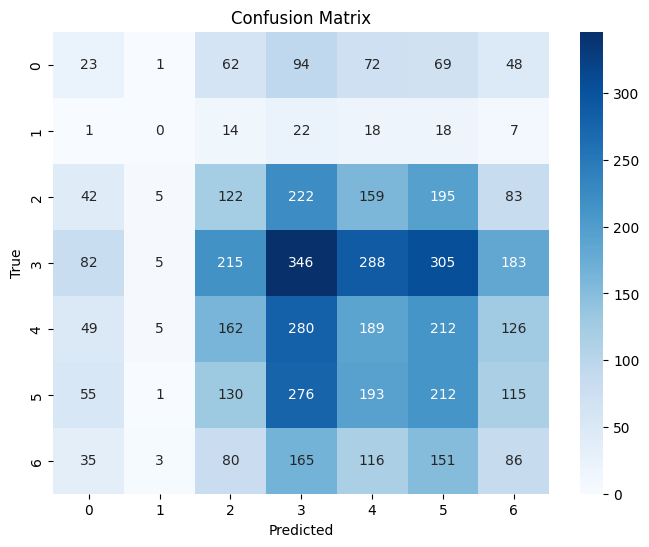

In [32]:
import seaborn as sns
cm = tf.math.confusion_matrix(true_labels, predicted_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

<Axes: >

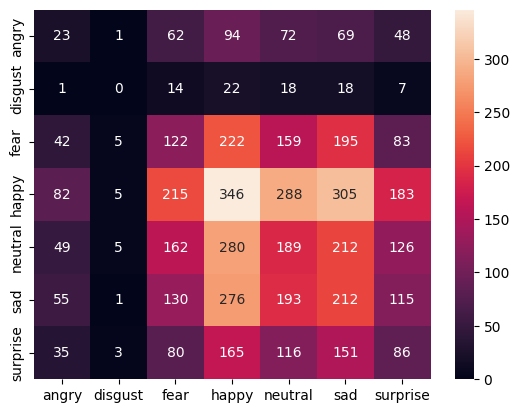

In [33]:
labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

sns.heatmap(cm,
            annot=True,
            fmt="d",
            xticklabels=labels,
            yticklabels=labels)

In [34]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_classes, target_names=labels))

              precision    recall  f1-score   support

       angry       0.08      0.06      0.07       369
     disgust       0.00      0.00      0.00        80
        fear       0.16      0.15      0.15       828
       happy       0.25      0.24      0.24      1424
     neutral       0.18      0.18      0.18      1023
         sad       0.18      0.22      0.20       982
    surprise       0.13      0.14      0.13       636

    accuracy                           0.18      5342
   macro avg       0.14      0.14      0.14      5342
weighted avg       0.18      0.18      0.18      5342



2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 893ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 747ms/step


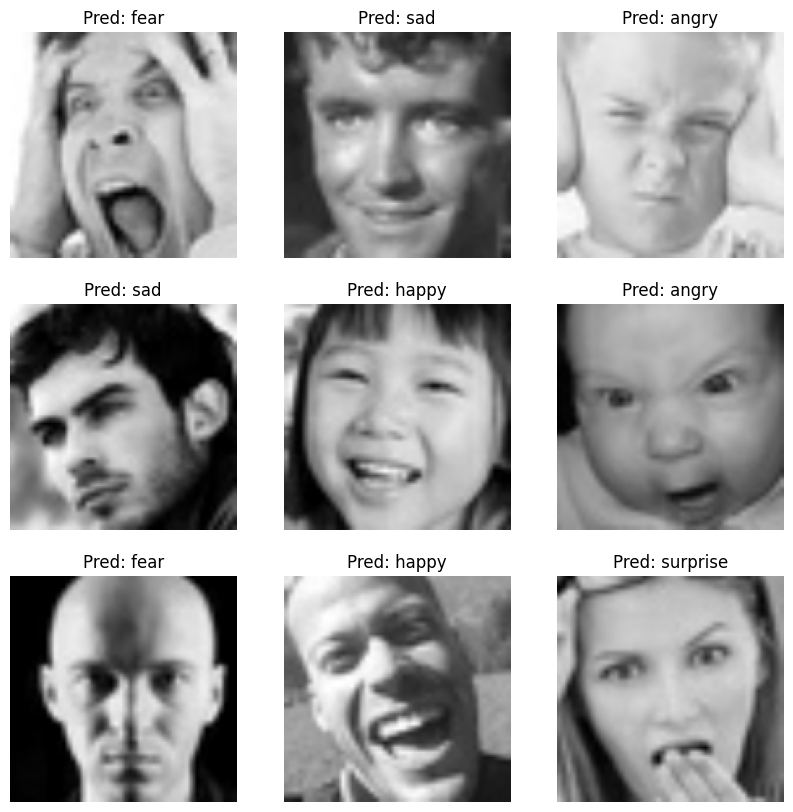

In [36]:
plt.figure(figsize=(10,10))

for images, labels_batch in val_ds_1.take(2):
    preds = model.predict(images)
    pred_labels = np.argmax(preds, axis=1)

    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Pred: {labels[pred_labels[i]]}")
        plt.axis("off")

plt.show()

In [55]:
def residual_block(x, filters, strides =1):
    
    shortcut = x
    #first layer
    x = layers.Conv2D(filters, kernel_size =3, strides = strides, padding='same') (x)
    x = layers.BatchNormalization() (x)
    x = layers.ReLU()(x)

    #second layer
    x = layers.Conv2D(filters, kernel_size =3, padding='same') (x)
    x = layers.BatchNormalization() (x)

    #adjusting the shortcut if shape changes
    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides = strides, padding = 'same') (shortcut)
        shortcut = layers.BatchNormalization() (shortcut)
    
    #skip connections
    x = layers.Add()([x, shortcut])
    x = layers.ReLU() (x)

    return x


Each bottleneck layer will have 3 convolutional layers.

In [10]:
def bottleneck_block(x, filters, stride =1):
    shortcut = x
    #1st layer
    x = layers.Conv2D(filters,1, strides= 1, padding ='same') (x)
    x = layers.BatchNormalization() (x)
    x= layers.ReLU()(x)
    #2nd layer
    x = layers.Conv2D(filters,3,strides= stride, padding ='same') (x)
    x = layers.BatchNormalization() (x)
    x= layers.ReLU()(x)
    #3rd layer
    x = layers.Conv2D(filters * 4, 1,strides= 1, padding ='same') (x)
    x = layers.BatchNormalization() (x)

    if stride != 1 or shortcut.shape[-1] != filters * 4:
        shortcut = layers.Conv2D(filters * 4, 1, strides= stride, padding ='same') (shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x= layers.Add()([x, shortcut])
    x = layers.ReLU()(x)

    return x
    

In [11]:
def resnet_50(input_shape=(140, 140, 3), num_classes=7):
    inputs = layers.Input(shape=input_shape)

    # Initial layers
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Conv2_x (3 blocks)
    x = bottleneck_block(x, 64)
    x = bottleneck_block(x, 64)
    x = bottleneck_block(x, 64)

    # Conv3_x (4 blocks)
    x = bottleneck_block(x, 128, stride=2)
    x = bottleneck_block(x, 128)
    x = bottleneck_block(x, 128)
    x = bottleneck_block(x, 128)

    # Conv4_x (6 blocks)
    x = bottleneck_block(x, 256, stride=2)
    for _ in range(5):
        x = bottleneck_block(x, 256)

    # Conv5_x (3 blocks)
    x = bottleneck_block(x, 512, stride=2)
    x = bottleneck_block(x, 512)
    x = bottleneck_block(x, 512)

    # Classification head
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model


In [12]:
model = resnet_50(input_shape=(140, 140, 3), num_classes=7)

In [ ]:
    #x = layers.Flatten() (x)
    #x = layers.Dense(1024, activation='relu') (x)

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [43]:
keras.utils.plot_model(model, show_shapes=True, expand_nested=True, dpi=64)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [14]:
history = model.fit(train_ds_1, validation_data=val_ds_1, epochs = 5)

Epoch 1/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2721 - loss: 2.1795

AbortedError: Graph execution error:

Detected at node StatefulPartitionedCall/functional_1/conv2d_44_1/BiasAdd defined at (most recent call last):
<stack traces unavailable>
Operation received an exception:Status: 1, message: could not create a memory object, in file tensorflow/core/kernels/mkl/mkl_conv_ops.cc:1112
	 [[{{node StatefulPartitionedCall/functional_1/conv2d_44_1/BiasAdd}}]] [Op:__inference_multi_step_on_iterator_46357]